# IMPORT LIBRARIES AND TRAINING ADD-ONs

In [ ]:
# for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


In [ ]:
#for transfer learning 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.applications import  MobileNetV2, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenetv2


In [ ]:
#@title Required to save models in HDF5 
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Gradio
!pip install gradio --quiet
import gradio as gr

In [ ]:
#@title Link to/Import Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#@title Numpy, Matplotlib, OS 
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
#@title TensorFlow, Keras and others
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D, AveragePooling2D
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow import keras


In [ ]:
#@title CODE TO DRAW LEARNING CURVE 
def draw_learning_curve(history):
  plt.figure(figsize=(20,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.show()

In [ ]:
#@title EARLY STOPPING CODE
from tensorflow.keras.callbacks import EarlyStopping
stop =  EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)


In [ ]:
#Importing MobileNetV2
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from imageio import imread


HOW DECAY RATES WORKS:
https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b

exponential decay: “ α = ( decayRate^(epochNumber) )*α0 “



In [ ]:
batch_size0=60

In [ ]:
#@title LEARNING RATE DECAY
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=(1020/batch_size0)*51,
    decay_rate=0.8,
    staircase=True)



NameError: ignored

In [ ]:
#@title CUSTOMIZE OPTIMIZERS (Adam,SGD)
from tensorflow.keras.optimizers import Adam, SGD
optim_sgd = SGD(lr_schedule)
optim_adam = Adam(lr_schedule)

NameError: ignored

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 4, # if for the past 3 epochs, the accuracy remians constant
                                            factor = 0.6, # decrease the learning rate by 0.6
                                            min_lr = 0.00001)
# Defining Callbacks

filepath = './best_weights.hdf5'
filepath2 = './vgg_19_best_weights.hdf5'

checkpoint_model    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', # model with maximum val_accuracy is saved
                                save_best_only=True,  #save model with best weights
                                verbose = 1)

checkpoint_model2    = ModelCheckpoint(filepath2, 
                                monitor = 'val_accuracy', 
                                mode='max', # model with maximum val_accuracy is saved
                                save_best_only=True,  #save model with best weights
                                verbose = 1)
callback_list = [learning_rate_reduction, checkpoint_model]

callback_list2 = [learning_rate_reduction, checkpoint_model2]

# IMPORT oxford_flowers102 DATASET

In [ ]:
#@title Dùng TensorFlow Datasets để load bộ data oxford_flowers102
import tensorflow_datasets as tfds

(train, val, test), info = tfds.load('oxford_flowers102', 
                                      split=['train', 'validation', 'test'],
                                      shuffle_files=True,
                                      as_supervised=True, 
                                      with_info=True)

In [ ]:
#@title Lưu danh sách tên vào file txt
f = open("flower_names.txt", "w")
f.write(info.features['label'].names[0])

i=1
while i<102:
  f.write(" \n")
  f.write(info.features['label'].names[i])
  i+=1
f.close()


# DATA PREPROCESSING

In [ ]:
from tensorflow import cast, float32
from tensorflow.data.experimental import AUTOTUNE
from tensorflow import one_hot 
from tensorflow.image import resize

def preprocess_data(image, label):
  """
  Normalizes images: `uint8` -> `float32`.
  One hot encoding labels
  Resize to (224, 224)
  """


  return resize(cast(image, float32)/255. , [224, 224]), one_hot(label, 102)



In [ ]:
train_data = train.map(
    preprocess_data, num_parallel_calls=AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(info.splits['train'].num_examples)
train_data = train_data.batch(batch_size0)
train_data = train_data.prefetch(AUTOTUNE)

In [ ]:
val_data = val.map(
    preprocess_data, num_parallel_calls=AUTOTUNE)
val_data = val_data.batch(batch_size0)
val_data = val_data.cache()
val_data = val_data.prefetch(AUTOTUNE)

In [ ]:
test_data = test.map(
    preprocess_data, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size0)
test_data = test_data.cache()
test_data = test_data.prefetch(AUTOTUNE)

#VGG 16

In [ ]:
#use VGG16 pre-trained model
def create_Base_model_from_VGG16():
   
    model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
    # don't train existing weights 
    for layer in model.layers:
      layer.trainable = False

    return model

In [ ]:
## Adding custom layes to base model

def add_custom_layers():
    #Adding custom Layers 
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)

    predictions = tf.keras.layers.Dense(102, activation="softmax")(x)
    
    # creating the final model 
    final_model = tf.keras.models.Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return final_model

In [ ]:
epochs = 25
#start = time.time()

model_from_vgg16 = add_custom_layers()
history2 = model_from_vgg16.fit(test_data,
                    epochs=epochs,
                    validation_data=val_data,
                    #validation_steps=5,
                    verbose=1,
                    callbacks = callback_list # giving the callback list
                     )


58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/25
103/103 [==============================] - ETA: 0s - loss: 2.8615 - accuracy: 0.3679
Epoch 1: val_accuracy improved from -inf to 0.41961, saving model to ./best_weights.hdf5
103/103 [==============================] - 61s 447ms/step - loss: 2.8615 - accuracy: 0.3679 - val_loss: 2.1900 - val_accuracy: 0.4196 - lr: 0.0010
Epoch 2/25
103/103 [==============================] - ETA: 0s - loss: 0.8073 - accuracy: 0.7858
Epoch 2: val_accuracy improved from 0.41961 to 0.60000, saving model to ./best_weights.hdf5
103/103 [==============================] - 38s 368ms/step - loss: 0.8073 - accuracy: 0.7858 - val_loss: 1.4550 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/25
103/103 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.9314
Epoch 3: val_accuracy improved from 0.60000 to 0.60784, saving model to ./best_weights.hdf5
103/103 [==============================] - 40s 386ms/step - loss: 0.2800 - accur

In [ ]:
model_from_vgg16.save('model_vgg16.h5')

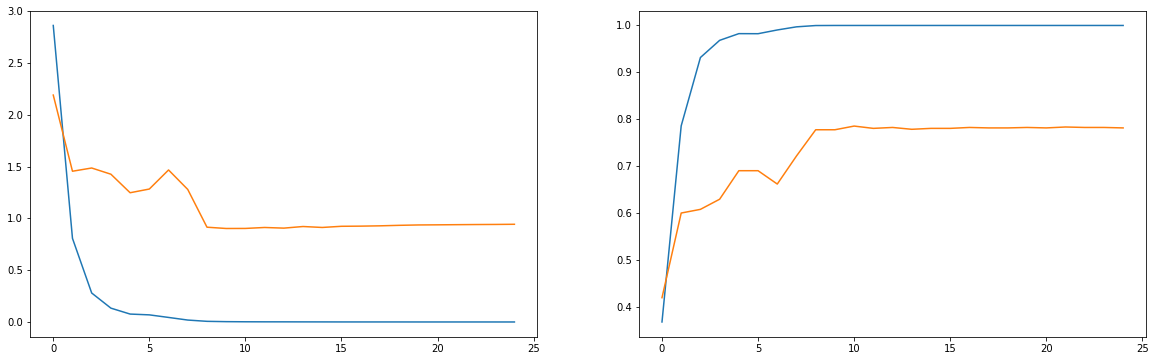

In [ ]:
draw_learning_curve(history2)

# VGG 19

In [ ]:
#use VGG19 pre-trained model
def create_Base_model_from_VGG19():
   
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
    # don't train existing weights 
    for layer in model.layers:
      layer.trainable = False

    return model

In [ ]:
## Adding custom layes to base model

def add_custom_layers_VGG19():
    #Adding custom Layers 
    model = create_Base_model_from_VGG19()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)


    predictions = tf.keras.layers.Dense(102, activation="softmax")(x)
    
    # creating the final model 
    final_model = tf.keras.models.Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return final_model

In [ ]:
epochs = 25
#start = time.time()

model_from_vgg19 = add_custom_layers_VGG19()
history3 = model_from_vgg19.fit(test_data,
                    epochs=epochs,
                    validation_data=val_data,
                    #validation_steps=5,
                    verbose=1,
                    callbacks = callback_list2 # giving the callback list
                     )

80150528/80134624 [==============================] - 0s 0us/step
Epoch 1/25
103/103 [==============================] - ETA: 0s - loss: 4.8604 - accuracy: 0.3466
Epoch 1: val_accuracy improved from -inf to 0.48235, saving model to ./vgg_19_best_weights.hdf5
103/103 [==============================] - 70s 537ms/step - loss: 4.8604 - accuracy: 0.3466 - val_loss: 2.0822 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 2/25
103/103 [==============================] - ETA: 0s - loss: 0.8170 - accuracy: 0.8112
Epoch 2: val_accuracy improved from 0.48235 to 0.64216, saving model to ./vgg_19_best_weights.hdf5
103/103 [==============================] - 46s 448ms/step - loss: 0.8170 - accuracy: 0.8112 - val_loss: 1.3656 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 3/25
103/103 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.9462
Epoch 3: val_accuracy improved from 0.64216 to 0.67157, saving model to ./vgg_19_best_weights.hdf5
103/103 [==============================] - 45s 440ms/step -

Từ thực nghiệm thấy rằng, việc dùng nhiều layer ít nodes sẽ kém hiệu quả hơn 1 layer nhiều nodes

In [ ]:
model_from_vgg19.save('model_vgg19.h5')

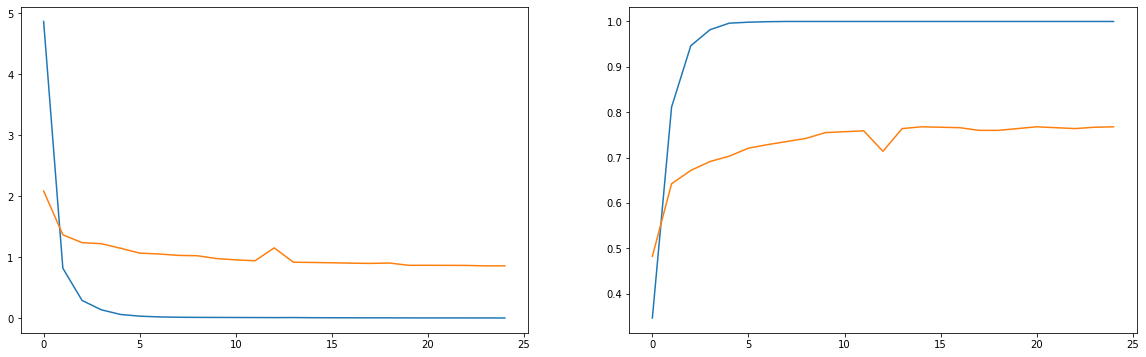

In [ ]:
draw_learning_curve(history3)

# VGG16_TRAIN

In [ ]:
#use VGG16 pre-trained model
def create_train_model_from_VGG16():
   
    model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
    # don't train existing weights 
    for layer in model.layers:
      layer.trainable = True

    return model

## Adding custom layes to base model

def add_custom_train_layers_VGG16():
    #Adding custom Layers 
    model = create_train_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)

    predictions = tf.keras.layers.Dense(102, activation="softmax")(x)
    
    # creating the final model 
    final_model = tf.keras.models.Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return final_model

In [ ]:
epochs = 25
#start = time.time()

model_train_from_vgg16 = add_custom_train_layers_VGG16()
history5 = model_train_from_vgg16.fit(test_data,
                    epochs=epochs,
                    validation_data=val_data,
                    #validation_steps=5,
                    verbose=1,
                    callbacks = callback_list2 # giving the callback list
                     )

Epoch 1/25
103/103 [==============================] - ETA: 0s - loss: 4.4807 - accuracy: 0.0384
Epoch 1: val_accuracy improved from -inf to 0.02549, saving model to ./vgg_19_best_weights.hdf5
103/103 [==============================] - 122s 972ms/step - loss: 4.4807 - accuracy: 0.0384 - val_loss: 4.6147 - val_accuracy: 0.0255 - lr: 0.0010
Epoch 2/25
103/103 [==============================] - ETA: 0s - loss: 4.0122 - accuracy: 0.0898
Epoch 2: val_accuracy improved from 0.02549 to 0.03333, saving model to ./vgg_19_best_weights.hdf5
103/103 [==============================] - 88s 856ms/step - loss: 4.0122 - accuracy: 0.0898 - val_loss: 4.5581 - val_accuracy: 0.0333 - lr: 0.0010
Epoch 3/25
103/103 [==============================] - ETA: 0s - loss: 3.6628 - accuracy: 0.1254
Epoch 3: val_accuracy improved from 0.03333 to 0.08039, saving model to ./vgg_19_best_weights.hdf5
103/103 [==============================] - 88s 858ms/step - loss: 3.6628 - accuracy: 0.1254 - val_loss: 4.1570 - val_accura

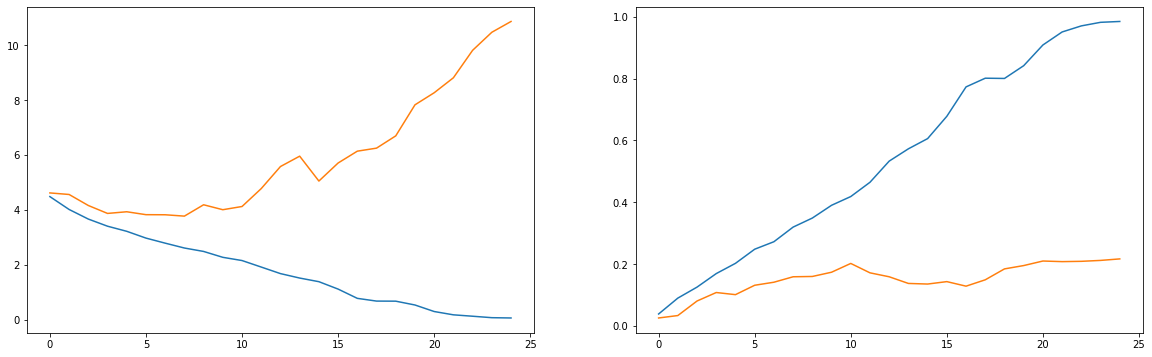

In [ ]:
draw_learning_curve(history5)

In [ ]:
model_train_from_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# GRADIO - USER INTERFACE

In [ ]:
model_from_vgg19 = add_custom_layers_VGG19()
model_from_vgg19.load_weights('/content/drive/MyDrive/Colab Notebooks/vgg_19_best_weights.hdf5')
#model_from_vgg19 = ('/content/model_vgg19.h5')


In [ ]:
with open('/content/flower_names.txt') as f:
    labels = f.readlines()

In [ ]:
def image_to_output (input_img):
  #gr_img0 = image.load_img(input_img, target_size=(100,100,3))
  #gr_img0 = image.img_to_array(gr_img0)

  gr_img=[]
  #gr_img.append(gr_img0)
  gr_img.append(input_img)

  x_test=np.asarray(gr_img)/255.

  prediction = model_from_vgg19.predict(x_test,batch_size=1).flatten()
  confidences = {labels[i]: float(prediction[i]) for i in range(102)}
  return confidences

In [ ]:
import gradio as gr

gr.Interface(fn=image_to_output, 
             inputs=gr.inputs.Image(shape=(224, 224)),
             outputs=gr.outputs.Label(num_top_classes=5),
             ).launch()

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://25103.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f3aaa064550>,
 'http://127.0.0.1:7865/',
 'https://25103.gradio.app')

ERROR:asyncio:Exception in callback None(<Task finishe...> result=None>)
handle: <Handle>
Traceback (most recent call last):
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
TypeError: 'NoneType' object is not callable
